# Model

## Setup

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', None)  

import sys, os, yaml

DATASET = "Boston"
COLAB = 'google.colab' in sys.modules

DEBUG = False
SEED = 666

In [110]:
COLAB = 'google.colab' in sys.modules

if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
    d = "/content/gdrive/MyDrive/datasets"
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
  if not os.path.isdir(ROOT): os.makedirs(ROOT)
else:
  ROOT = "./"

def makedirs(d):
  if COLAB:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  else:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)

## Load Dataset

In [111]:
df = pd.read_pickle(f"{ROOT}/data/boston.pickle")
df.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [112]:
X = df.drop("TARGET", axis=True)
X.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [113]:
y = df.TARGET
y.head()

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: TARGET, dtype: float64

## Baseline Model

In [114]:
from sklearn.model_selection import train_test_split 

train = 0.8 / test = 0.2

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = SEED)

In [116]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [117]:
classifiers = {
    "DTR" : DecisionTreeRegressor(),
    "DTR(max_depth=5)" : DecisionTreeRegressor(max_depth=5),
    "LR" : LinearRegression(),
    "SVR()" : SVR(),
    "SVR(kernel='linear')" : SVR(kernel='linear'),
}

In [118]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

`cross_val_score` é uma função do scikit-learn que é usada para realizar validação cruzada de forma conveniente. A validação cruzada é uma técnica comum para avaliar a capacidade de generalização de um modelo, especialmente em conjuntos de dados pequenos.

In [119]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)  # 5-fold cross-validation with shuffling

for name, model in classifiers.items():
    model.fit(X_train, y_train)

    mse_train_cross_val_score = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

    mse_train_cross_val_score = -mse_train_cross_val_score  # invert the sign back to positive

    r2_train_cross_val_score = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

    print(f"{name:20s} mse_cross_val_score\ttrain = {mse_train_cross_val_score.mean()}\tr2_cross_val_score\ttrain = {r2_train_cross_val_score.mean()}")


DTR                  mse_cross_val_score	train = 29.671184876543208	r2_cross_val_score	train = 0.6491315382216022
DTR(max_depth=5)     mse_cross_val_score	train = 26.75523381743658	r2_cross_val_score	train = 0.6431507130871592
LR                   mse_cross_val_score	train = 22.983165257062588	r2_cross_val_score	train = 0.7305786872425731
SVR()                mse_cross_val_score	train = 70.24441041769279	r2_cross_val_score	train = 0.19429916598881508
SVR(kernel='linear') mse_cross_val_score	train = 25.320926500025667	r2_cross_val_score	train = 0.704337250555765


In [122]:
from sklearn.preprocessing import StandardScaler

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)  # 5-fold cross-validation with shuffling
scaler = StandardScaler()

for name, model in classifiers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    model.fit(X_train_scaled, y_train)

    mse_train_cross_val_score = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
    mse_train_cross_val_score = -mse_train_cross_val_score  # invert the sign back to positive

    r2_train_cross_val_score = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='r2')

    print(f"{name:20s} mse_cross_val_score\ttrain = {mse_train_cross_val_score.mean()}\tr2_cross_val_score\ttrain = {r2_train_cross_val_score.mean()}")


DTR                  mse_cross_val_score	train = 29.462148456790125	r2_cross_val_score	train = 0.6581713898780881
DTR(max_depth=5)     mse_cross_val_score	train = 29.830461299836337	r2_cross_val_score	train = 0.6664763559094788
LR                   mse_cross_val_score	train = 22.983165257062677	r2_cross_val_score	train = 0.7305786872425717
SVR()                mse_cross_val_score	train = 31.29182998250007	r2_cross_val_score	train = 0.6428278025197331
SVR(kernel='linear') mse_cross_val_score	train = 24.584550673552194	r2_cross_val_score	train = 0.7124382893889015


DTR                  mse_score	train = 0.0 	test = 34.04166666666667
DTR                  r2_score	train = 1.0 	test = 0.5415458466256466


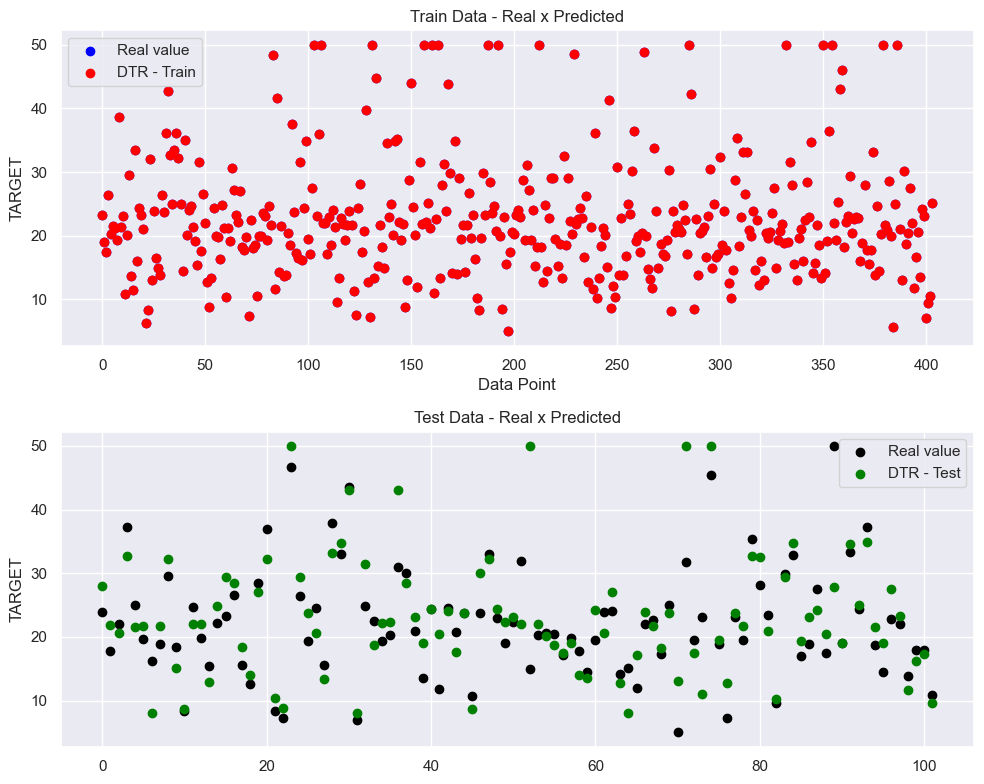

DTR(max_depth=5)     mse_score	train = 7.054838066976622 	test = 34.544269800713536
DTR(max_depth=5)     r2_score	train = 0.9188611315308103 	test = 0.5347770683352353


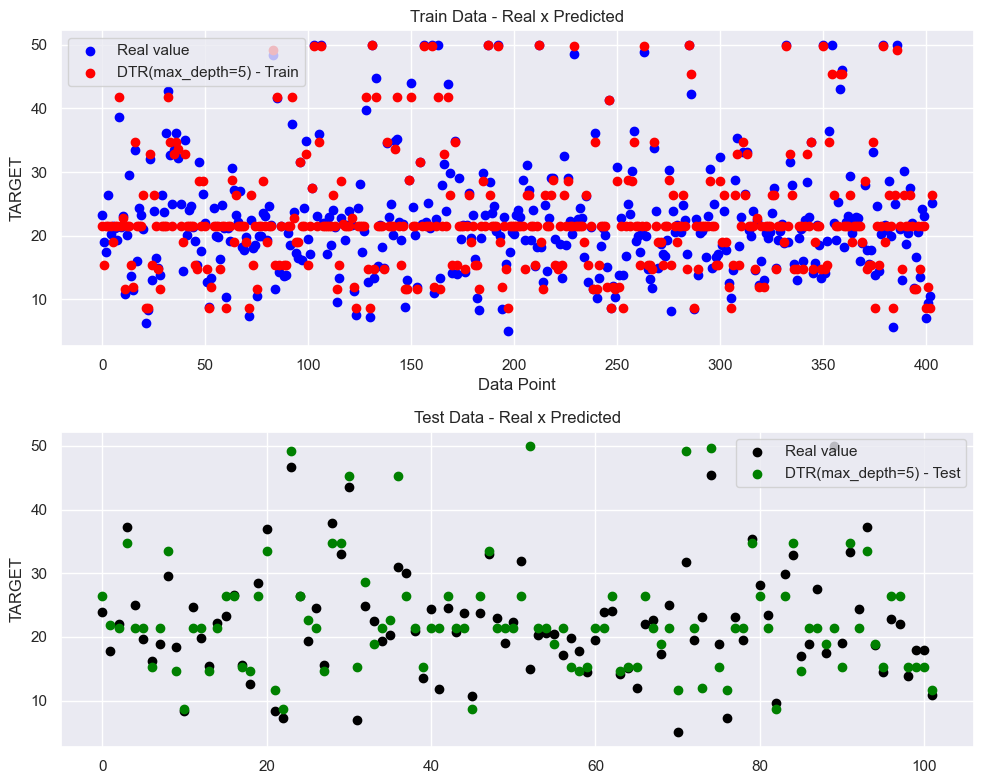

LR                   mse_score	train = 21.24691896590841 	test = 28.807853683707396
LR                   r2_score	train = 0.7556356436556478 	test = 0.6120319166385415


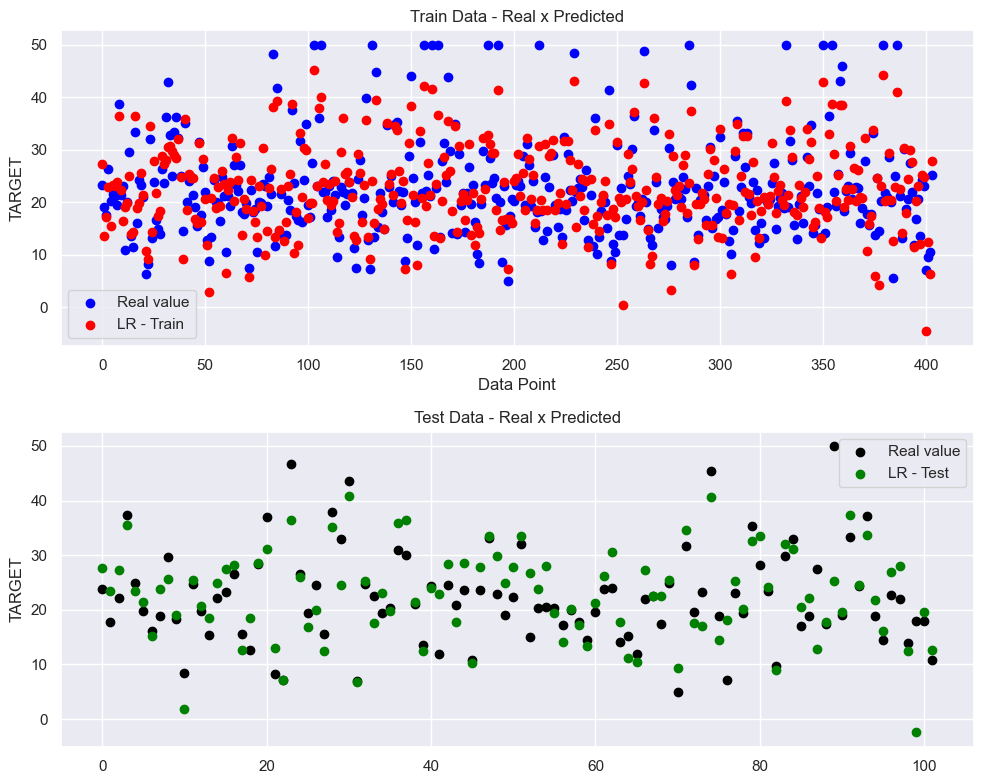

SVR()                mse_score	train = 26.08961499312912 	test = 24.091801987349545
SVR()                r2_score	train = 0.6999389894931348 	test = 0.6755450668287031


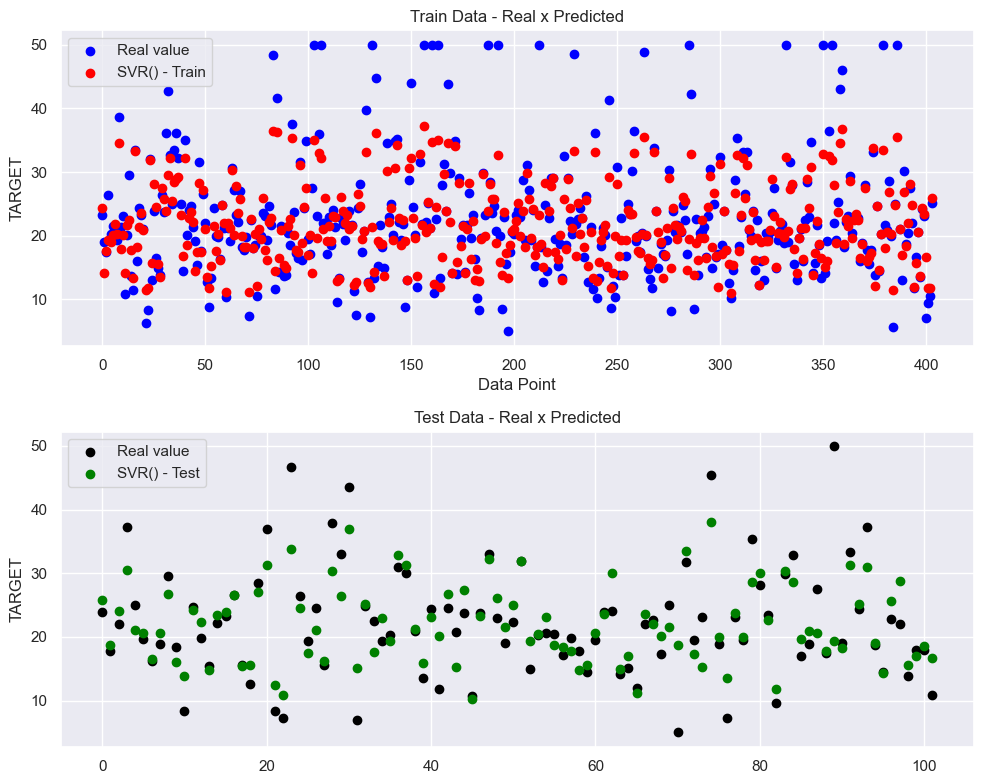

SVR(kernel='linear') mse_score	train = 23.412922872270514 	test = 29.767804409270592
SVR(kernel='linear') r2_score	train = 0.7307240717111789 	test = 0.5991038364279415


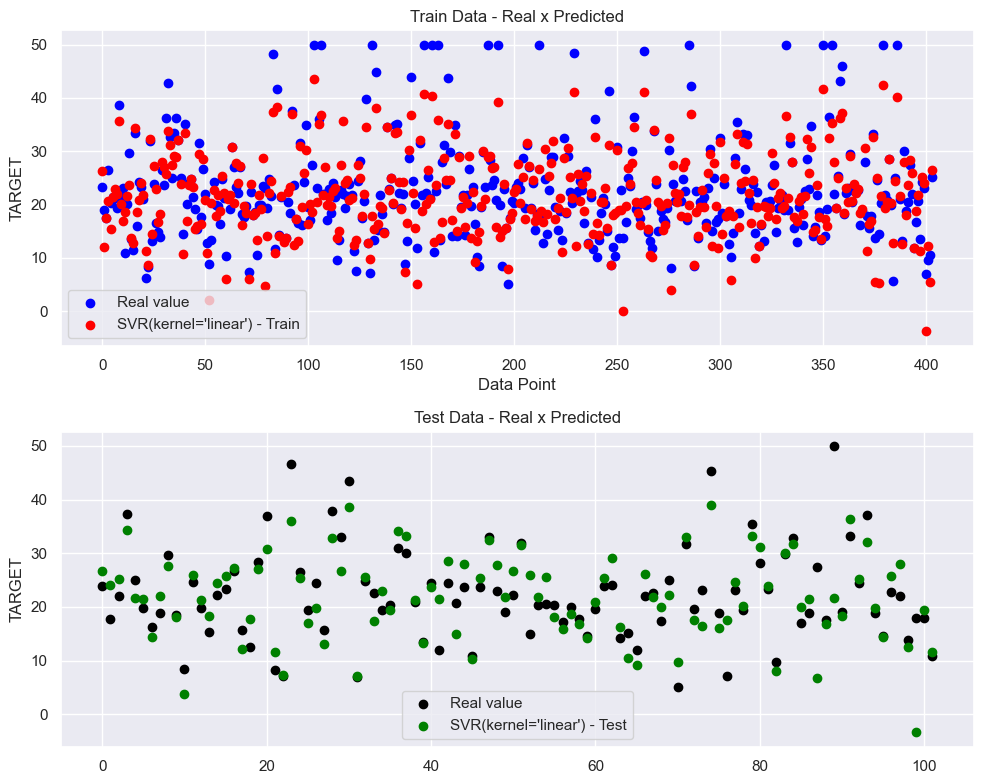

In [123]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

for name, model in classifiers.items():
    
    model.fit(X_train, y_train)
    
    # Scoring on SEEN data - effectively "useless"
    y_pred_train = model.predict(X_train)
    train_r2_score = r2_score(y_train, y_pred_train)
    train_mse_score = mean_squared_error(y_train, y_pred_train)

    # Scoring on UNSEEN data - important
    y_pred = model.predict(X_test)
    test_r2_score = r2_score(y_test, y_pred)
    test_mse_score = mean_squared_error(y_test, y_pred)
    
    print(f"{name:20s} mse_score\ttrain = {train_mse_score} \ttest = {test_mse_score}")
    print(f"{name:20s} r2_score\ttrain = {train_r2_score} \ttest = {test_r2_score}")

    plt.figure(figsize=(10, 8))

    # Plot for train data
    plt.subplot(2, 1, 1)
    x_train = np.arange(len(y_train))
    plt.scatter(x=x_train, y=y_train, color="blue", label="Real value")
    plt.scatter(x=x_train, y=y_pred_train, color="red", label=f"{name} - Train")
    plt.legend()
    plt.xlabel("Data Point")
    plt.ylabel("TARGET")
    plt.title("Train Data - Real x Predicted")

    # Plot for test data
    plt.subplot(2, 1, 2)
    x_test = np.arange(len(y_test))
    plt.scatter(x=x_test, y=y_test, color="black", label="Real value")
    plt.scatter(x=x_test, y=y_pred, color="green", label=f"{name} - Test")
    plt.legend()
    plt.ylabel("TARGET")
    plt.title("Test Data - Real x Predicted")

    plt.tight_layout()
    plt.show()
